## Projeto Panificadora 

# 🥖 Laboratório: Análise de Dados SAF-T de Padaria/Pastelaria

## 📋 Contexto

Neste laboratório vais trabalhar com dados **reais e muito sujos** de uma padaria/pastelaria portuguesa. O ficheiro que recebeste é um export direto de **SAF-T (Standard Audit File for Tax purposes)** - o formato oficial usado em Portugal para reportar dados fiscais.

**O Grande Desafio - Dados do Mundo Real:**

Este ficheiro está **intencionalmente mal estruturado** (como vem dos sistemas reais):

- ❌ **86.000+ linhas** todas misturadas numa única sheet
- ❌ **62 colunas** com prefixos XML (`ns1:`)
- ❌ Dados de diferentes tipos misturados (header, produtos, vendas, impostos)
- ❌ Milhares de valores nulos onde não devia haver
- ❌ Colunas repetidas com sufixos numéricos
- ❌ Zero estrutura - tudo num Excel gigante

**O Teu Trabalho:**

1. **Explorar** este caos e perceber o que há lá dentro
2. **Extrair** apenas os dados de vendas relevantes
3. **Reestruturar** criando sheets organizadas (Produtos, Vendas, etc.)
4. **Limpar** e transformar para análise
5. **Analisar** e extrair insights de negócio

**Tecnologias:** Python, Pandas, Matplotlib, openpyxl

**Expectativa Real:** Vais passar 70% do tempo a limpar dados. É assim no mundo real. 😅

-----------------------------------------------------------------

### Data Science na Prática - Introdução ao Python e Modelos Preditivos
Projeto: Análise de Vendas e Impostos
Este projeto tem como objetivo analisar um conjunto de dados de vendas e impostos para identificar padrões, tendências e insights que possam ajudar a empresa a otimizar suas operações e estratégias de vendas. O dataset inclui informações sobre transações de vendas, códigos de impostos, produtos e outras variáveis relevantes.

As etapas do projeto incluem:
0. Carregamento dos dados
1. Tratamento e limpeza dos dados
2. Análise exploratória dos dados
3. Visualização dos dados
4. Modelagem preditiva (opcional, dependendo dos insights encontrados)

Por Karen Pessoa

[Clique aqui para acessar a Documentação (README)](readme_padaria.ipynb)

---------------------------------------------------------------------------------

### 0. Carregamento de bibliotecas e datasets

In [1]:
# Bibliotecas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [2]:
# Carregando o dataset
def load_data(path):
    df = pd.read_excel(path)
    return df

def standardize_columns(df):
    df = df.copy()
    df.columns = df.columns.str.replace('ns1:', '', regex=False)
    return df

df_raw = load_data("SAF-T-RAW_v2.xlsx")
df_raw = standardize_columns(df_raw)

### 1. Tratamento e limpeza dos dados

In [3]:
# Visualizando as colunas do dataset
df_raw.columns

Index(['AuditFileVersion', 'TaxAccountingBasis', 'BusinessName', 'Country',
       'FiscalYear', 'StartDate', 'EndDate', 'CurrencyCode', 'DateCreated',
       'TaxEntity', 'SoftwareCertificateNumber', 'ProductVersion', 'Fax',
       'Email', 'ProductType', 'ProductCode', 'ProductDescription',
       'ProductNumberCode', 'TaxType', 'TaxCountryRegion', 'TaxCode',
       'Description', 'TaxPercentage', 'TotalDebit', 'InvoiceStatus',
       'InvoiceStatusDate', 'SourceID', 'SourceBilling', 'Hash', 'HashControl',
       'Period', 'InvoiceDate', 'InvoiceType', 'SelfBillingIndicator26',
       'CashVATSchemeIndicator', 'ThirdPartiesBillingIndicator', 'SourceID27',
       'SystemEntryDate', 'DeliveryDate', 'DeliveryDate34',
       'MovementStartTime', 'LineNumber', 'ProductCode40',
       'ProductDescription41', 'Quantity', 'UnitOfMeasure', 'UnitPrice',
       'TaxPointDate', 'Description42', 'CreditAmount', 'TaxType43',
       'TaxCountryRegion44', 'TaxCode45', 'TaxPercentage46',
       'TaxE

In [4]:
# Filtrando apenas as colunas relevantes para a análise

COLUNAS_SISTEMA = [
    'AuditFileVersion', 'TaxAccountingBasis', 'BusinessName',
    'Country', 'FiscalYear', 'StartDate', 'EndDate', 'CurrencyCode',
    'DateCreated', 'TaxEntity', 'SoftwareCertificateNumber',
    'ProductVersion', 'Fax', 'Email', 'ProductType', 'Description', 
    'TotalDebit', 'InvoiceStatus', 'InvoiceStatusDate', 'SourceID', 
    'SourceBilling', 'Hash', 'HashControl', 'Period', 'InvoiceDate', 
    'InvoiceType', 'SelfBillingIndicator26', 'CashVATSchemeIndicator',
    'ThirdPartiesBillingIndicator', 'SystemEntryDate',
    'DeliveryDate', 'DeliveryDate34', 'TaxType43',
    'TaxCountryRegion44', 'PaymentMechanism'
]

def clean_data(df):
    cols_to_drop = [c for c in COLUNAS_SISTEMA if c in df.columns]
    df_clean = df.drop(columns=cols_to_drop)
    return df_clean

df_clean = clean_data(df_raw)

In [5]:
# Visualizando as colunas do dataset após a limpeza inicial
df_clean.columns

Index(['ProductCode', 'ProductDescription', 'ProductNumberCode', 'TaxType',
       'TaxCountryRegion', 'TaxCode', 'TaxPercentage', 'SourceID27',
       'MovementStartTime', 'LineNumber', 'ProductCode40',
       'ProductDescription41', 'Quantity', 'UnitOfMeasure', 'UnitPrice',
       'TaxPointDate', 'Description42', 'CreditAmount', 'TaxCode45',
       'TaxPercentage46', 'TaxExemptionReason', 'TaxExemptionCode',
       'TaxPayable', 'NetTotal', 'GrossTotal', 'PaymentAmount', 'PaymentDate'],
      dtype='str')

In [6]:
# Dividindo o dataset em tabelas menores por tipo de informação

tax_master_cols = [
    'TaxType', 'TaxCountryRegion',
    'TaxCode', 'TaxPercentage'
]

df_tax_master = (
    df_clean[tax_master_cols]
    .dropna(how='all')
    .drop_duplicates()
)

product_columns = [
    'ProductCode', 'ProductDescription', 
    'ProductNumberCode'
]

df_products = (
    df_clean[product_columns]
    .dropna(how='all')
    .drop_duplicates()
)

cols_to_exclude = set(df_tax_master.columns).union(set(df_products.columns))

df_sales = df_clean[[col for col in df_clean.columns if col not in cols_to_exclude]].copy()



In [7]:
print(df_tax_master)

    TaxType TaxCountryRegion TaxCode  TaxPercentage
474     IVA               PT     INT           13.0
475     IVA               PT     ISE            0.0
476     IVA               PT     NOR           23.0
477     IVA               PT     RED            6.0


In [8]:
print(df_products)

    ProductCode         ProductDescription ProductNumberCode
20         1002                  Coca-cola              1002
21         1003             Agua ,33 s/gas              1003
22         1004           Agua c/gas Frize              1004
23         1005            Agua s/gas 0,5l              1005
24         1007        Pão Caseiro Pequeno              1007
..          ...                        ...               ...
469        4000  Polpa de Tomate Amanhecer     5601227044584
470        4002          Trancetto Morango     8001585001026
471        4003           Madalenas Aurora     5600744051174
472        4501                guardanapos     5601028000352
473        4502  Farinha de Milho Ceifeira     5605786000241

[454 rows x 3 columns]


In [9]:
# Checando tamanho do dataset de vendas
df_sales.shape


(86013, 20)

In [10]:
# Checando os tipos de dados
df_sales.dtypes

SourceID27                         str
MovementStartTime       datetime64[us]
LineNumber                     float64
ProductCode40                      str
ProductDescription41               str
Quantity                       float64
UnitOfMeasure                      str
UnitPrice                      float64
TaxPointDate            datetime64[us]
Description42                      str
CreditAmount                   float64
TaxCode45                          str
TaxPercentage46                float64
TaxExemptionReason                 str
TaxExemptionCode                   str
TaxPayable                     float64
NetTotal                       float64
GrossTotal                     float64
PaymentAmount                  float64
PaymentDate             datetime64[us]
dtype: object

In [11]:
# Checando valores ausentes
df_sales.isna().sum().sort_values(ascending=False)


TaxExemptionReason      82625
TaxExemptionCode        82625
SourceID27                478
MovementStartTime         478
ProductCode40             478
LineNumber                478
ProductDescription41      478
Quantity                  478
TaxPointDate              478
Description42             478
UnitOfMeasure             478
UnitPrice                 478
TaxCode45                 478
CreditAmount              478
TaxPercentage46           478
TaxPayable                478
NetTotal                  478
GrossTotal                478
PaymentAmount             478
PaymentDate               478
dtype: int64

In [12]:
# Ajustando a categoria de taxas fiscais
mask_isento = df_sales['TaxCode45'] == 'ISE'

df_sales.loc[mask_isento, 'TaxCode45'] = (
    df_sales.loc[mask_isento, 'TaxCode45']
    + ' - '
    + df_sales.loc[mask_isento, 'TaxExemptionCode']
)
print(df_sales['TaxCode45'].value_counts())


TaxCode45
INT          36319
RED          31447
NOR          14381
ISE - M26     2446
ISE - M11      939
ISE - M05        3
Name: count, dtype: int64


In [13]:
# Removendo colunas de isenção fiscal que não serão mais necessárias
df_sales = df_sales.drop(columns=['TaxExemptionReason', 'TaxExemptionCode'])
df_sales.isna().sum().sort_values(ascending=False)

SourceID27              478
MovementStartTime       478
LineNumber              478
ProductCode40           478
ProductDescription41    478
Quantity                478
UnitOfMeasure           478
UnitPrice               478
TaxPointDate            478
Description42           478
CreditAmount            478
TaxCode45               478
TaxPercentage46         478
TaxPayable              478
NetTotal                478
GrossTotal              478
PaymentAmount           478
PaymentDate             478
dtype: int64

In [14]:
# Removendo linhas completamente vazias
df_sales = df_sales.dropna(how='all')
df_sales.isna().sum().sort_values(ascending=False)

SourceID27              0
MovementStartTime       0
LineNumber              0
ProductCode40           0
ProductDescription41    0
Quantity                0
UnitOfMeasure           0
UnitPrice               0
TaxPointDate            0
Description42           0
CreditAmount            0
TaxCode45               0
TaxPercentage46         0
TaxPayable              0
NetTotal                0
GrossTotal              0
PaymentAmount           0
PaymentDate             0
dtype: int64

In [15]:
df_sales.head()

,SourceID27,MovementStartTime,LineNumber,ProductCode40,ProductDescription41,Quantity,UnitOfMeasure,UnitPrice,TaxPointDate,Description42,CreditAmount,TaxCode45,TaxPercentage46,TaxPayable,NetTotal,GrossTotal,PaymentAmount,PaymentDate
478,EB,2024-01-02 11:21:00,1.0,1007,PÃO CASEIRO PEQUENO,2.0,Unidade,1.18,2024-01-02,Pão Caseiro Pequeno,2.36,RED,6.0,0.14,2.36,2.50,2.50,2024-01-02
479,EB,2024-01-02 11:26:00,1.0,1442,CACETE / VIANA,5.0,Unidade,0.45,2024-01-02,Cacete / Viana,2.25,ISE - M26,0.0,0.00,2.25,2.25,2.25,2024-01-02
480,EB,2024-01-02 11:32:00,1.0,1013,BOLA CASEIRA,2.0,Unidade,0.45,2024-01-02,Bola Caseira,0.90,ISE - M26,0.0,0.00,0.90,0.90,0.90,2024-01-02
481,EB,2024-01-02 11:34:00,1.0,1007,PÃO CASEIRO PEQUENO,1.0,Unidade,1.18,2024-01-02,Pão Caseiro Pequeno,1.18,RED,6.0,0.15,1.80,1.95,1.95,2024-01-02
482,EB,2024-01-02 11:34:00,2.0,1056,CAFÉ,1.0,Unidade,0.62,2024-01-02,Café,0.62,INT,13.0,0.15,1.80,1.95,1.95,2024-01-02


In [16]:
# Checando divergências entre as descrições dos produtos
df_sales['test'] = (df_sales['ProductDescription41'] != df_sales['Description42'].str.upper()).astype(int)
df_divergentes = df_sales[df_sales['test'] == 1]
print(df_divergentes[['ProductDescription41', 'Description42', 'test']])

      ProductDescription41 Description42  test
54806  PÃO CASEIRO PEQUENO          1,35     1


In [17]:
# Ajustando as descrições dos produtos para o mesmo formato
df_sales['Description42'] = df_sales['ProductDescription41'].str.title()
df_sales['ProductDescription41'] = df_sales['ProductDescription41'].str.title()
print(df_sales[['ProductDescription41', 'Description42', 'test']])

      ProductDescription41        Description42  test
478    Pão Caseiro Pequeno  Pão Caseiro Pequeno     0
479         Cacete / Viana       Cacete / Viana     0
480           Bola Caseira         Bola Caseira     0
481    Pão Caseiro Pequeno  Pão Caseiro Pequeno     0
482                   Café                 Café     0
...                    ...                  ...   ...
86008                 Fofa                 Fofa     0
86009         Bola Caseira         Bola Caseira     0
86010                 Fofa                 Fofa     0
86011  Pão Caseiro Pequeno  Pão Caseiro Pequeno     0
86012      Agua S/Gas 0,5L      Agua S/Gas 0,5L     0

[85535 rows x 3 columns]


In [18]:
# Alterando tipo float para int para as colunas de número da linha e porcentagem de imposto
df_sales['LineNumber'] = df_sales['LineNumber'].astype(int)
df_sales['TaxPercentage46'] = df_sales['TaxPercentage46'].astype(int)

In [19]:
# Criando ID de venda e ID de linha de venda
df_sales = df_sales.reset_index(drop=True)

# 1. Identifica onde começa uma nova venda (LineNumber == 1)
# Isso cria uma série de True/False
nova_venda = (df_sales['LineNumber'] == 1)

# 2. Transforma True em 1 e False em 0, e vai somando
# Assim, o ID só aumenta quando encontra um novo LineNumber 1
df_sales['sale_id'] = nova_venda.cumsum()

# 3. Agora cria o sale_line_id usando o novo sale_id numérico
df_sales['sale_line_id'] = (
    df_sales['sale_id'].astype(str) 
    + '.' 
    + df_sales['LineNumber'].astype(str)
)

In [20]:
print(df_sales['sale_line_id'])

0            1.1
1            2.1
2            3.1
3            4.1
4            4.2
          ...   
85530    43125.1
85531    43125.2
85532    43125.3
85533    43126.1
85534    43127.1
Name: sale_line_id, Length: 85535, dtype: str


In [21]:
# Criando colunas de data e hora a partir da coluna datetime
df_sales['hora'] = df_sales["MovementStartTime"].dt.hour 
df_sales["dia"] = df_sales["MovementStartTime"].dt.day 
df_sales["dia_semana"] = df_sales["MovementStartTime"].dt.day_of_week + 1
df_sales["mes"] = df_sales["MovementStartTime"].dt.month 

In [22]:
df_sales.columns

Index(['SourceID27', 'MovementStartTime', 'LineNumber', 'ProductCode40',
       'ProductDescription41', 'Quantity', 'UnitOfMeasure', 'UnitPrice',
       'TaxPointDate', 'Description42', 'CreditAmount', 'TaxCode45',
       'TaxPercentage46', 'TaxPayable', 'NetTotal', 'GrossTotal',
       'PaymentAmount', 'PaymentDate', 'test', 'sale_id', 'sale_line_id',
       'hora', 'dia', 'dia_semana', 'mes'],
      dtype='str')

In [23]:
# Retirando colunas desnecessárias e renomeando para ficar mais intuitivo
df_sales = df_sales.drop(columns=['SourceID27', 'TaxPointDate', 'Description42', 'sale_id', 'test'])
df_sales = df_sales.rename(columns={'sale_line_id': 'sale_id'})



In [24]:
df_sales.head()

,MovementStartTime,LineNumber,ProductCode40,ProductDescription41,Quantity,UnitOfMeasure,UnitPrice,CreditAmount,TaxCode45,TaxPercentage46,TaxPayable,NetTotal,GrossTotal,PaymentAmount,PaymentDate,sale_id,hora,dia,dia_semana,mes
0,2024-01-02 11:21:00,1,1007,Pão Caseiro Pequeno,2.0,Unidade,1.18,2.36,RED,6,0.14,2.36,2.50,2.50,2024-01-02,1.1,11,2,2,1
1,2024-01-02 11:26:00,1,1442,Cacete / Viana,5.0,Unidade,0.45,2.25,ISE - M26,0,0.00,2.25,2.25,2.25,2024-01-02,2.1,11,2,2,1
2,2024-01-02 11:32:00,1,1013,Bola Caseira,2.0,Unidade,0.45,0.90,ISE - M26,0,0.00,0.90,0.90,0.90,2024-01-02,3.1,11,2,2,1
3,2024-01-02 11:34:00,1,1007,Pão Caseiro Pequeno,1.0,Unidade,1.18,1.18,RED,6,0.15,1.80,1.95,1.95,2024-01-02,4.1,11,2,2,1
4,2024-01-02 11:34:00,2,1056,Café,1.0,Unidade,0.62,0.62,INT,13,0.15,1.80,1.95,1.95,2024-01-02,4.2,11,2,2,1


In [25]:
df_sales.shape

(85535, 20)

In [26]:
df_sales.duplicated().sum()

np.int64(0)

In [ ]:
# retirar o prefixo 'ns1:' das colunas
# retirar colunas desnecessárias: 
# # 'AuditFileVersion', 'TaxAccountingBasis', 'BusinessName', 'Country',
  #     'FiscalYear', 'StartDate', 'EndDate', 'CurrencyCode', 'DateCreated',
  #     'TaxEntity', 'SoftwareCertificateNumber', 'ProductVersion', 'Fax',
  #     'Email', 'TotalDebit', 'InvoiceStatus', 
  #     'InvoiceStatusDate', 'SourceID', 'SourceBilling', 'Hash', 'HashControl',
  #     'Period', 'InvoiceDate', 'InvoiceType', 'SelfBillingIndicator26',
  #     'CashVATSchemeIndicator', 'ThirdPartiesBillingIndicator',
  #     'SystemEntryDate', 'DeliveryDate', 'DeliveryDate34', 'TaxType43', 
  #     'TaxCountryRegion44', 'PaymentMechanism', 
  
  

# informações sobre os produtos:
# # 'ProductType', 'ProductCode', 'ProductDescription', 'ProductNumberCode'

# informações sobre taxas fiscais:
# # 'TaxType', 'TaxCountryRegion', 'TaxCode', 'Description', 'TaxPercentage'

# iformações sobre as vendas:
# # 
  #     'InvoiceStatusDate', 'SourceID', 'SourceBilling', 'Hash', 'HashControl',
  #     'Period', 'InvoiceDate', 'InvoiceType', 'SelfBillingIndicator26',
  #     'CashVATSchemeIndicator', 'ThirdPartiesBillingIndicator', 'SourceID27',
  #     'SystemEntryDate', 'DeliveryDate', 'DeliveryDate34',
  #     'MovementStartTime', 'LineNumber', 'ProductCode40',
  #     'ProductDescription41', 'Quantity', 'UnitOfMeasure', 'UnitPrice',
  #     'TaxPointDate', 'Description42', 'CreditAmount', 'TaxType43',
  #     'TaxCountryRegion44', 'TaxCode45', 'TaxPercentage46',
  #     'TaxExemptionReason', 'TaxExemptionCode', 'TaxPayable', 'NetTotal',
  #     'GrossTotal', 'PaymentMechanism', 'PaymentAmount', 'PaymentDate'

# mudanças nas colunas:
# df[TaxCode45] = if df[TaxCode45] == "ISE": df[TaxCode45] + " - " + df[TaxExemptionCode] else df[TaxCode45] # categorização de taxação fiscal

# verificar se 
# # ProductCode = ProductCode40
# # ProductDescription = ProductDescription41
# # TaxType = TaxType43
# # TaxCountryRegion = TaxCountryRegion44
# # TaxCode = TaxCode45
# # TaxPercentage = TaxPercentage46
# # criar id para as vendas: MovementStartTime + LineNumber # podemos contabilizar os clientes únicos a partir disso, e também criar um id para cada linha de venda

# criar id único para cada linha
# df_sales['id'] = df_sales.index + 1


### 2. Análise exploratória 

In [27]:
# Período de vendas:
print(df_sales['MovementStartTime'].min())
print(df_sales['MovementStartTime'].max())

2024-01-02 11:21:00
2024-12-08 19:01:00


Ps.: A coluna PaymentAmount replica o valor da fatura para cada linha que compõe a fatura. O valor por produto está na coluna CreditAmount, porém sem incluir o imposto. Para encontrarmos o faturamento real ( com e sem impostos ) iremos criar um subset: df_invoice

In [37]:
# Total de vendas (linhas de venda):
df_invoice = df_sales[df_sales['LineNumber'] == 1]
print(df_invoice['sale_id'].nunique())

43127


In [29]:
# Faturamento total e médio por venda:
print(df_invoice['PaymentAmount'].sum().round(2))
print(df_invoice['PaymentAmount'].mean().round(2))

128469.99
2.98


In [30]:
# Faturamento total e médio (mensal) por venda:
print(df_invoice.groupby('mes')['PaymentAmount'].sum().round(2))
print(df_invoice.groupby('mes')['PaymentAmount'].mean().round(2))

mes
1      9439.56
2     10146.85
3     10744.92
4     10585.34
5     10604.13
6     10678.73
7     12904.19
8     13306.91
9     13371.16
10    12769.32
11    11156.10
12     2762.78
Name: PaymentAmount, dtype: float64
mes
1     3.06
2     2.97
3     3.12
4     2.97
5     2.97
6     2.88
7     2.90
8     3.02
9     2.95
10    3.05
11    2.89
12    3.08
Name: PaymentAmount, dtype: float64


In [31]:
df_invoice.columns

Index(['MovementStartTime', 'LineNumber', 'ProductCode40',
       'ProductDescription41', 'Quantity', 'UnitOfMeasure', 'UnitPrice',
       'CreditAmount', 'TaxCode45', 'TaxPercentage46', 'TaxPayable',
       'NetTotal', 'GrossTotal', 'PaymentAmount', 'PaymentDate', 'sale_id',
       'hora', 'dia', 'dia_semana', 'mes'],
      dtype='str')

In [36]:
# Faturamento por produto:
# 1. Criar a coluna do valor real (Bruto) por linha
# Fórmula: Valor Sem Imposto * (1 + (Percentual / 100))
df_sales['GrossPayment'] = df_sales['CreditAmount'] * (1 + (df_sales['TaxPercentage46'] / 100))

# 2. Agrupar por produto, somar o valor real, ordenar e pegar o Top 5
top_5_faturamento = (
    df_sales.groupby('ProductDescription41')['GrossPayment']
    .agg(Total_Faturado='sum', Media_por_Item='mean', Qtd_Vendas='count') 
    .sort_values(by='Total_Faturado', ascending=False)
    .head(5)
    .reset_index()
)

# 3. Formatação para exibir como dinheiro (opcional, mas fica profissional)

print(top_5_faturamento.round(2).to_string(index=False))

    ProductDescription41  Total_Faturado  Media_por_Item  Qtd_Vendas
                    Café        13716.96            0.97       14168
     Pão Caseiro Pequeno        11744.96            1.59        7393
            Lucky Strike        10046.60            5.56        1808
Bolos P/ Consumo Interno         7726.09            1.41        5463
                    Fofa         6859.46            1.21        5660


In [ ]:
 corrigir 
# 1. Garantir a venda_raiz (o XX antes do ponto)
df_sales['num_fatura'] = df_sales['sale_id'].astype(str).str.split('.').str[0]

print(df_invoice.groupby('ProductDescription41')['PaymentAmount'].sum().sort_values(ascending=False).head(5))
print(df_invoice.groupby('ProductDescription41')['PaymentAmount'].sum().sort_values(ascending=True).head(5))

ProductDescription41
Café                        17388.50
Pão Caseiro Pequeno         14879.05
Fofa                         9206.55
Lucky Strike                 7218.53
Bolos P/ Consumo Interno     5607.60
Name: PaymentAmount, dtype: float64
ProductDescription41
Sobremesa/Iogurtes Solidos    0.50
Molho B.                      1.15
Cho.Lion                      1.20
Salsichas Dilop               1.30
Sumos 2L                      1.35
Name: PaymentAmount, dtype: float64


In [209]:
# Total acumulado de impostos:
print(df_invoice['TaxPayable'].sum().round(2))
print((df_invoice['TaxPayable'].sum() / df_invoice['PaymentAmount'].sum()).round(4))

12547.93
0.0977


In [210]:
# Total livre de impostos:
print(df_invoice['NetTotal'].sum().round(2))

115922.06


In [211]:
# Top produtos vendidos:
print(
    df_sales.groupby('ProductDescription41')['Quantity']
    .sum()                               # Soma as quantidades
    .sort_values(ascending=False)        # Ordena do mais vendido para o menos vendido
    .round(1)                            # Arredonda para 1 casa decimal
    .head(5)                             # Pega os cinco primeiros
)

ProductDescription41
Café                   18400.0
Fofa                   16005.0
Bebés                  13949.0
Pão Caseiro Pequeno     8728.0
Bola Caseira            6260.0
Name: Quantity, dtype: float64


In [212]:
# Top produtos vendidos por mês:
print(
    df_sales.groupby(['mes', 'ProductDescription41'])['Quantity']
    .sum()                               # Soma as quantidades
    .reset_index()                       # Transforma em DataFrame novamente
    .sort_values(['mes', 'Quantity'], ascending=[True, False]) # Ordena
    .groupby('mes')                      # Agrupa só por mês agora
    .head(2)                             # Pega o primeiro (o maior) de cada mês
    .reset_index(drop=True)              # Organiza o índice final
)

    mes ProductDescription41  Quantity
0     1                 Café    1346.0
1     1                 Fofa    1283.0
2     2                 Café    1429.0
3     2                 Fofa    1337.0
4     3                 Café    1521.0
5     3                 Fofa    1424.0
6     4                 Café    1604.0
7     4                 Fofa    1367.0
8     5                 Café    1671.0
9     5                 Fofa    1492.0
10    6                 Café    1703.0
11    6                 Fofa    1504.0
12    7                 Café    1705.0
13    7                 Fofa    1429.0
14    8                 Café    1752.0
15    8                 Fofa    1522.0
16    9                 Café    1967.0
17    9                 Fofa    1484.0
18   10                 Café    1691.0
19   10                 Fofa    1459.0
20   11                 Café    1614.0
21   11                 Fofa    1335.0
22   12                Bebés     409.0
23   12                 Café     397.0


Top mês

In [260]:
# Top mês em número de vendas:
print(
    df_sales[df_sales['LineNumber'] == 1].groupby(['mes'])[['Quantity']]
    .count()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

     Quantity
mes          
9        4537


In [261]:
# Top mês em faturamento:
print(
    df_invoice.groupby(['mes'])[['PaymentAmount']]
    .sum()                       # Soma as quantidades
    .sort_values(by='PaymentAmount', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

     PaymentAmount
mes               
9         13371.16


In [262]:
# Top mês em produtos vendidos:
print(
    df_sales.groupby(['mes'])[['Quantity']]
    .sum()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

      Quantity
mes           
8    13210.451


Top dia do mês

In [257]:
# Top dia do mês em número de vendas:
print(
    df_sales[df_sales['LineNumber'] == 1].groupby(['mes', 'dia'])[['Quantity']]
    .count()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

         Quantity
mes dia          
9   8         305


In [258]:
# Top dia do mês em faturamento:
print(
    df_invoice.groupby(['mes', 'dia'])[['PaymentAmount']]
    .sum()                       # Soma as quantidades
    .sort_values(by='PaymentAmount', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

         PaymentAmount
mes dia               
9   8          1054.94


In [259]:
# Top dia do mês em produtos vendidos:
print(
    df_sales.groupby(['mes', 'dia'])[['Quantity']]
    .sum()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

         Quantity
mes dia          
9   8       869.0


Top dia

In [224]:
# Top dia em número de vendas:
print(
    df_sales[df_sales['LineNumber'] == 1].groupby(['dia'])[['Quantity']]
    .count()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

     Quantity
dia          
8        1637


In [263]:
# Top dia em faturamento:
print(
    df_invoice.groupby(['dia'])[['PaymentAmount']]
    .sum()                       # Soma as quantidades
    .sort_values(by='PaymentAmount', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

     PaymentAmount
dia               
8          4963.94


In [264]:
# Top dia em produtos vendidos:
print(
    df_sales.groupby(['dia'])[['Quantity']]
    .sum()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

     Quantity
dia          
8    4794.001


Top dia_semana

In [230]:
# Top dia da semana em número de vendas:
print(
    df_sales[df_sales['LineNumber'] == 1].groupby(['dia_semana'])[['Quantity']]
    .count()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)
    

            Quantity
dia_semana          
5               6794


In [265]:
# Top dia da semana em faturamento:
print(
    df_invoice.groupby(['dia_semana'])[['PaymentAmount']]
    .sum()                       # Soma as quantidades
    .sort_values(by='PaymentAmount', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

            PaymentAmount
dia_semana               
5                21315.06


In [266]:
# Top dia da semana em produtos vendidos:
print(
    df_sales.groupby(['dia_semana'])[['Quantity']]
    .sum()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(1)                    # Pega o primeiro (o maior)
)

            Quantity
dia_semana          
7            21117.8


Top hora 

In [268]:
# Top hora em número de vendas:
print(
    df_sales[df_sales['LineNumber'] == 1].groupby(['hora'])[['Quantity']]
    .count()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(3)                    # Pega o primeiro (o maior)
)

      Quantity
hora          
12        4840
11        4129
8         3982


In [269]:
# Top hora em faturamento:
print(
    df_invoice.groupby(['hora'])[['PaymentAmount']]
    .sum()                       # Soma as quantidades
    .sort_values(by='PaymentAmount', ascending=False)    # Ordena
    .head(3)                    # Pega o primeiro (o maior)
)

      PaymentAmount
hora               
12         14012.56
11         13098.45
8          11593.56


In [270]:
# Top hora em produtos vendidos:
print(
    df_sales.groupby(['hora'])[['Quantity']]
    .sum()                       # Soma as quantidades
    .sort_values(by='Quantity', ascending=False)    # Ordena
    .head(3)                    # Pega o primeiro (o maior)
)

       Quantity
hora           
7     13594.900
8     13558.301
9     13057.640


Top combinados

In [277]:
# Top produtos vendidos juntos:
# 1. Garantir a venda_raiz (o XX antes do ponto)
df_sales['num_fatura'] = df_sales['sale_id'].astype(str).str.split('.').str[0]

# 2. Criar o merge, mas agora vamos multiplicar as quantidades
top_pares_qtd = (
    df_sales.merge(df_sales, on='num_fatura')
    .query('ProductDescription41_x < ProductDescription41_y')
)

# 3. Criar a métrica de peso (Quantidade X vezes Quantidade Y)
# Isso reflete o volume total de combinações possíveis naquela venda
top_pares_qtd['quant_comb'] = top_pares_qtd['Quantity_x'] * top_pares_qtd['Quantity_y']

# 4. Agrupar somando esse volume
resultado = (
    top_pares_qtd.groupby(['ProductDescription41_x', 'ProductDescription41_y'])['quant_comb']
    .sum()
    .reset_index()
    .sort_values(by='quant_comb', ascending=False)
    .head(5)
)

print(resultado)

        ProductDescription41_x ProductDescription41_y  quant_comb
1871                     Bebés                   Fofa      8184.0
3828                      Café                   Fofa      5806.0
1826                     Bebés                   Café      4310.0
2810  Bolos P/ Consumo Interno                   Café      3550.2
2866  Bolos P/ Consumo Interno                   Fofa      2812.8


In [278]:
# Acumulado de Pareto dos produtos mais vendidos ao longo do tempo:
# 1. Agrupar por mês e produto, somando a quantidade
vendas_mensais = df_sales.groupby(['mes', 'ProductDescription41'])['Quantity'].sum().reset_index()

# 2. Calcular o acumulado (cumsum) dentro de cada grupo de produto
vendas_mensais['acumulado'] = vendas_mensais.groupby('ProductDescription41')['Quantity'].cumsum()

# Exemplo: Ver a evolução dos 3 produtos mais vendidos no total
top_3_nomes = df_sales.groupby('ProductDescription41')['Quantity'].sum().nlargest(3).index
evolucao_top_3 = vendas_mensais[vendas_mensais['ProductDescription41'].isin(top_3_nomes)]

print(evolucao_top_3.pivot(index='mes', columns='ProductDescription41', values='acumulado'))

ProductDescription41      Bebés     Café     Fofa
mes                                              
1                      1148.000   1346.0   1283.0
2                      2248.000   2775.0   2620.0
3                      3418.000   4296.0   4044.0
4                      4585.001   5900.0   5411.0
5                      5903.001   7571.0   6903.0
6                      7102.002   9274.0   8407.0
7                      8268.002  10979.0   9836.0
8                      9739.003  12731.0  11358.0
9                     11006.003  14698.0  12842.0
10                    12265.003  16389.0  14301.0
11                    13540.003  18003.0  15636.0
12                    13949.003  18400.0  16005.0


In [292]:
# Curva de crescimento do faturamento total ao longo do tempo:
# 1. Agrupar por mês e dia, somando o faturamento real
faturamento_diario = df_invoice.groupby(['dia'])['PaymentAmount'].sum().reset_index()

# 2. Calcular o acumulado (cumsum) para ver o crescimento ao longo do ano
faturamento_diario['acumulado_ano'] = faturamento_diario['PaymentAmount'].cumsum()

# 3. Calcular o acumulado que "reseta" todo início de mês
# faturamento_diario['acumulado_mes'] = faturamento_diario.groupby('mes')['PaymentAmount'].cumsum()

print(faturamento_diario.head(10))

   dia  PaymentAmount  acumulado_ano
0    1        4277.34        4277.34
1    2        4198.66        8476.00
2    3        4448.80       12924.80
3    4        4494.52       17419.32
4    5        4625.92       22045.24
5    6        4341.23       26386.47
6    7        4897.46       31283.93
7    8        4963.94       36247.87
8    9        3921.79       40169.66
9   10        4219.06       44388.72


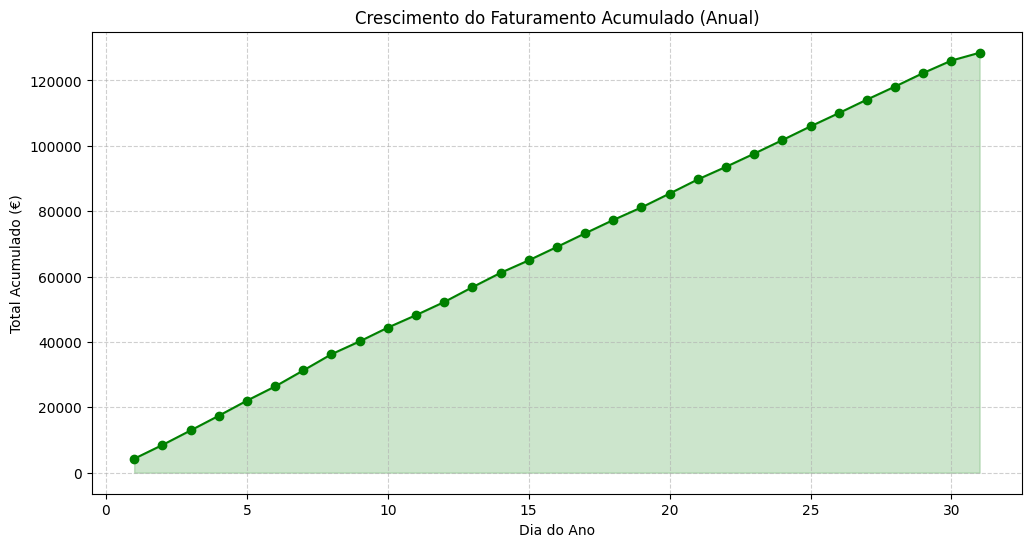

In [293]:
plt.figure(figsize=(12, 6))
plt.plot(faturamento_diario['dia'], faturamento_diario['acumulado_ano'], marker='o', linestyle='-', color='green')
plt.fill_between(faturamento_diario['dia'], faturamento_diario['acumulado_ano'], alpha=0.2, color='green')
plt.title('Crescimento do Faturamento Acumulado (Anual)')
plt.xlabel('Dia do Ano')
plt.ylabel('Total Acumulado (€)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

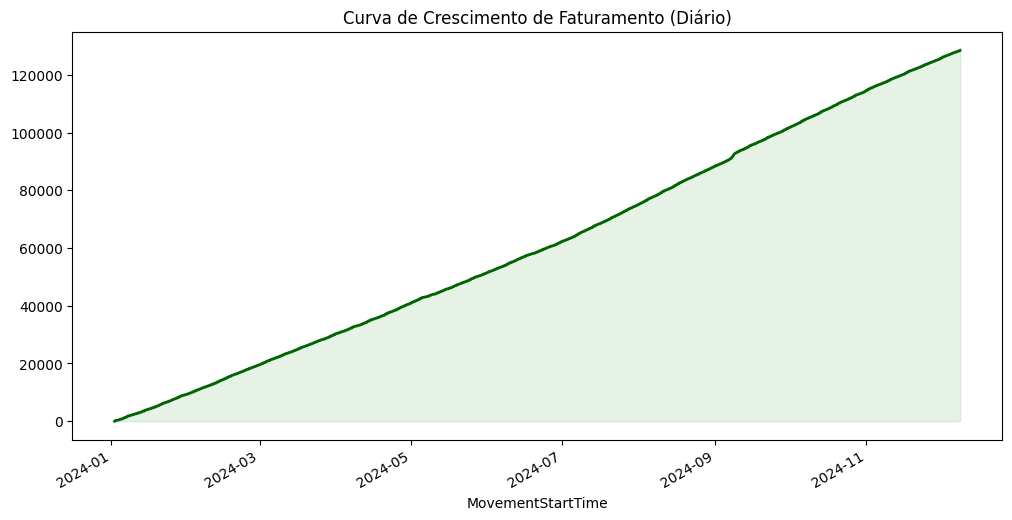

In [294]:
# Certifique-se de que a data está em ordem cronológica
df_invoice = df_invoice.sort_values('MovementStartTime')

# Acumulado diário em vez de mensal
faturamento_diario = df_invoice.groupby('MovementStartTime')['PaymentAmount'].sum().cumsum()

plt.figure(figsize=(12, 6))
faturamento_diario.plot(kind='line', color='darkgreen', linewidth=2)
plt.fill_between(faturamento_diario.index, faturamento_diario.values, alpha=0.1, color='green')
plt.title('Curva de Crescimento de Faturamento (Diário)')
plt.show()

In [155]:
# periodo de vendas
# faturamento anual
# faturamento mensal
# faturamento por produto
# faturamento por categoria de imposto
# total de vendas por cliente (a partir do id de venda)
# total de vendas por produto
# top produtos vendidos 
# top produtos vendidos por mês
# melhor período de vendas (dia da semana, mês, hora)
# top combinados de produtos vendidos juntos
# acumulado de vendas ao longo do tempo por produto
# categorias de produtos 


